<a href="https://colab.research.google.com/github/StasGT/Pedestrian-Tracking/blob/new/ByteTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Use GPU enviroment please.**

In [ ]:
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack
!ls
!pip3 install -r requirements.txt
!python3 setup.py develop

running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog

In [ ]:
#!pip install loguru
#!pip install thop
#!pip install lap
#!pip install cython_bbox
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
blosc2 3.5.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is inco

In [ ]:

import numpy as np
import torchvision.transforms as T

import argparse
import os
import os.path as osp
import time
import cv2
import torch

from loguru import logger

from yolox.data.data_augment import preproc
from yolox.exp import get_exp
from yolox.utils import fuse_model, get_model_info, postprocess
from yolox.utils.visualize import plot_tracking
from yolox.tracker.byte_tracker import BYTETracker
from yolox.tracking_utils.timer import Timer

!nvcc --version

/content/ByteTrack/yolox/tracker/kalman_filter.py:3: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.linalg


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


Necessary to load weights - https://drive.google.com/file/d/1P4mY0Yyd3PPTybgZkjMYhFri88nTmJX5/view?usp=sharing

And put it in the ByteTrack folder

In [ ]:
%cd ByteTrack
!ls
!python tools/demo_track.py video -f exps/example/mot/yolox_x_mix_det.py -c bytetrack_x_mot17.pth.tar --fp16 --fuse --save_result



[Errno 2] No such file or directory: 'ByteTrack'
/content/ByteTrack
assets			   Dockerfile	     setup.cfg	yolox
build			   exps		     setup.py	yolox.egg-info
bytetrack_x_mot17.pth.tar  LICENSE	     tools	YOLOX_outputs
datasets		   README.md	     tutorials
deploy			   requirements.txt  videos
2025-06-28 07:17:11.986 | INFO     | __main__:main:314 - Args: Namespace(demo='video', experiment_name='yolox_x_mix_det', name=None, path='./videos/palace.mp4', camid=0, save_result=True, exp_file='exps/example/mot/yolox_x_mix_det.py', ckpt='bytetrack_x_mot17.pth.tar', device=device(type='cuda'), conf=None, nms=None, tsize=None, fps=30, fp16=True, fuse=True, trt=False, track_thresh=0.5, track_buffer=30, match_thresh=0.8, aspect_ratio_thresh=1.6, min_box_area=10, mot20=False)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/Ten

**Input video is in the folder: ByteTrack/videos/**

**Output video in: ByteTrack/YOLOX_outputs/yolox_x_mix_det/track_vis/**

====================================================================

**Here we go!**

**Very simple DeTr + ByteTrack**

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from loguru import logger
from yolox.utils import fuse_model, get_model_info, postprocess
from yolox.utils.visualize import plot_tracking
from yolox.tracker.byte_tracker import BYTETracker
from yolox.tracking_utils.timer import Timer

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [ ]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h).cpu(),
                'pred_boxes': self.linear_bbox(h).sigmoid().cpu()}

[Errno 2] No such file or directory: 'ByteTrack'
/content/ByteTrack
assets			   Dockerfile	     setup.cfg	yolox
build			   exps		     setup.py	yolox.egg-info
bytetrack_x_mot17.pth.tar  LICENSE	     tools	YOLOX_outputs
datasets		   README.md	     tutorials
deploy			   requirements.txt  videos


  warnings.warn(

2025-06-28 09:26:27.885 | INFO     | __main__:imageflow_demo:121 - Processing frame 0 (100000.00 fps)
2025-06-28 09:26:29.662 | INFO     | __main__:imageflow_demo:121 - Processing frame 20 (12.83 fps)
2025-06-28 09:26:31.363 | INFO     | __main__:imageflow_demo:121 - Processing frame 40 (13.23 fps)
2025-06-28 09:26:33.050 | INFO     | __main__:imageflow_demo:121 - Processing frame 60 (13.36 fps)
2025-06-28 09:26:34.718 | INFO     | __main__:imageflow_demo:121 - Processing frame 80 (13.46 fps)
2025-06-28 09:26:36.558 | INFO     | __main__:imageflow_demo:121 - Processing frame 100 (13.32 fps)


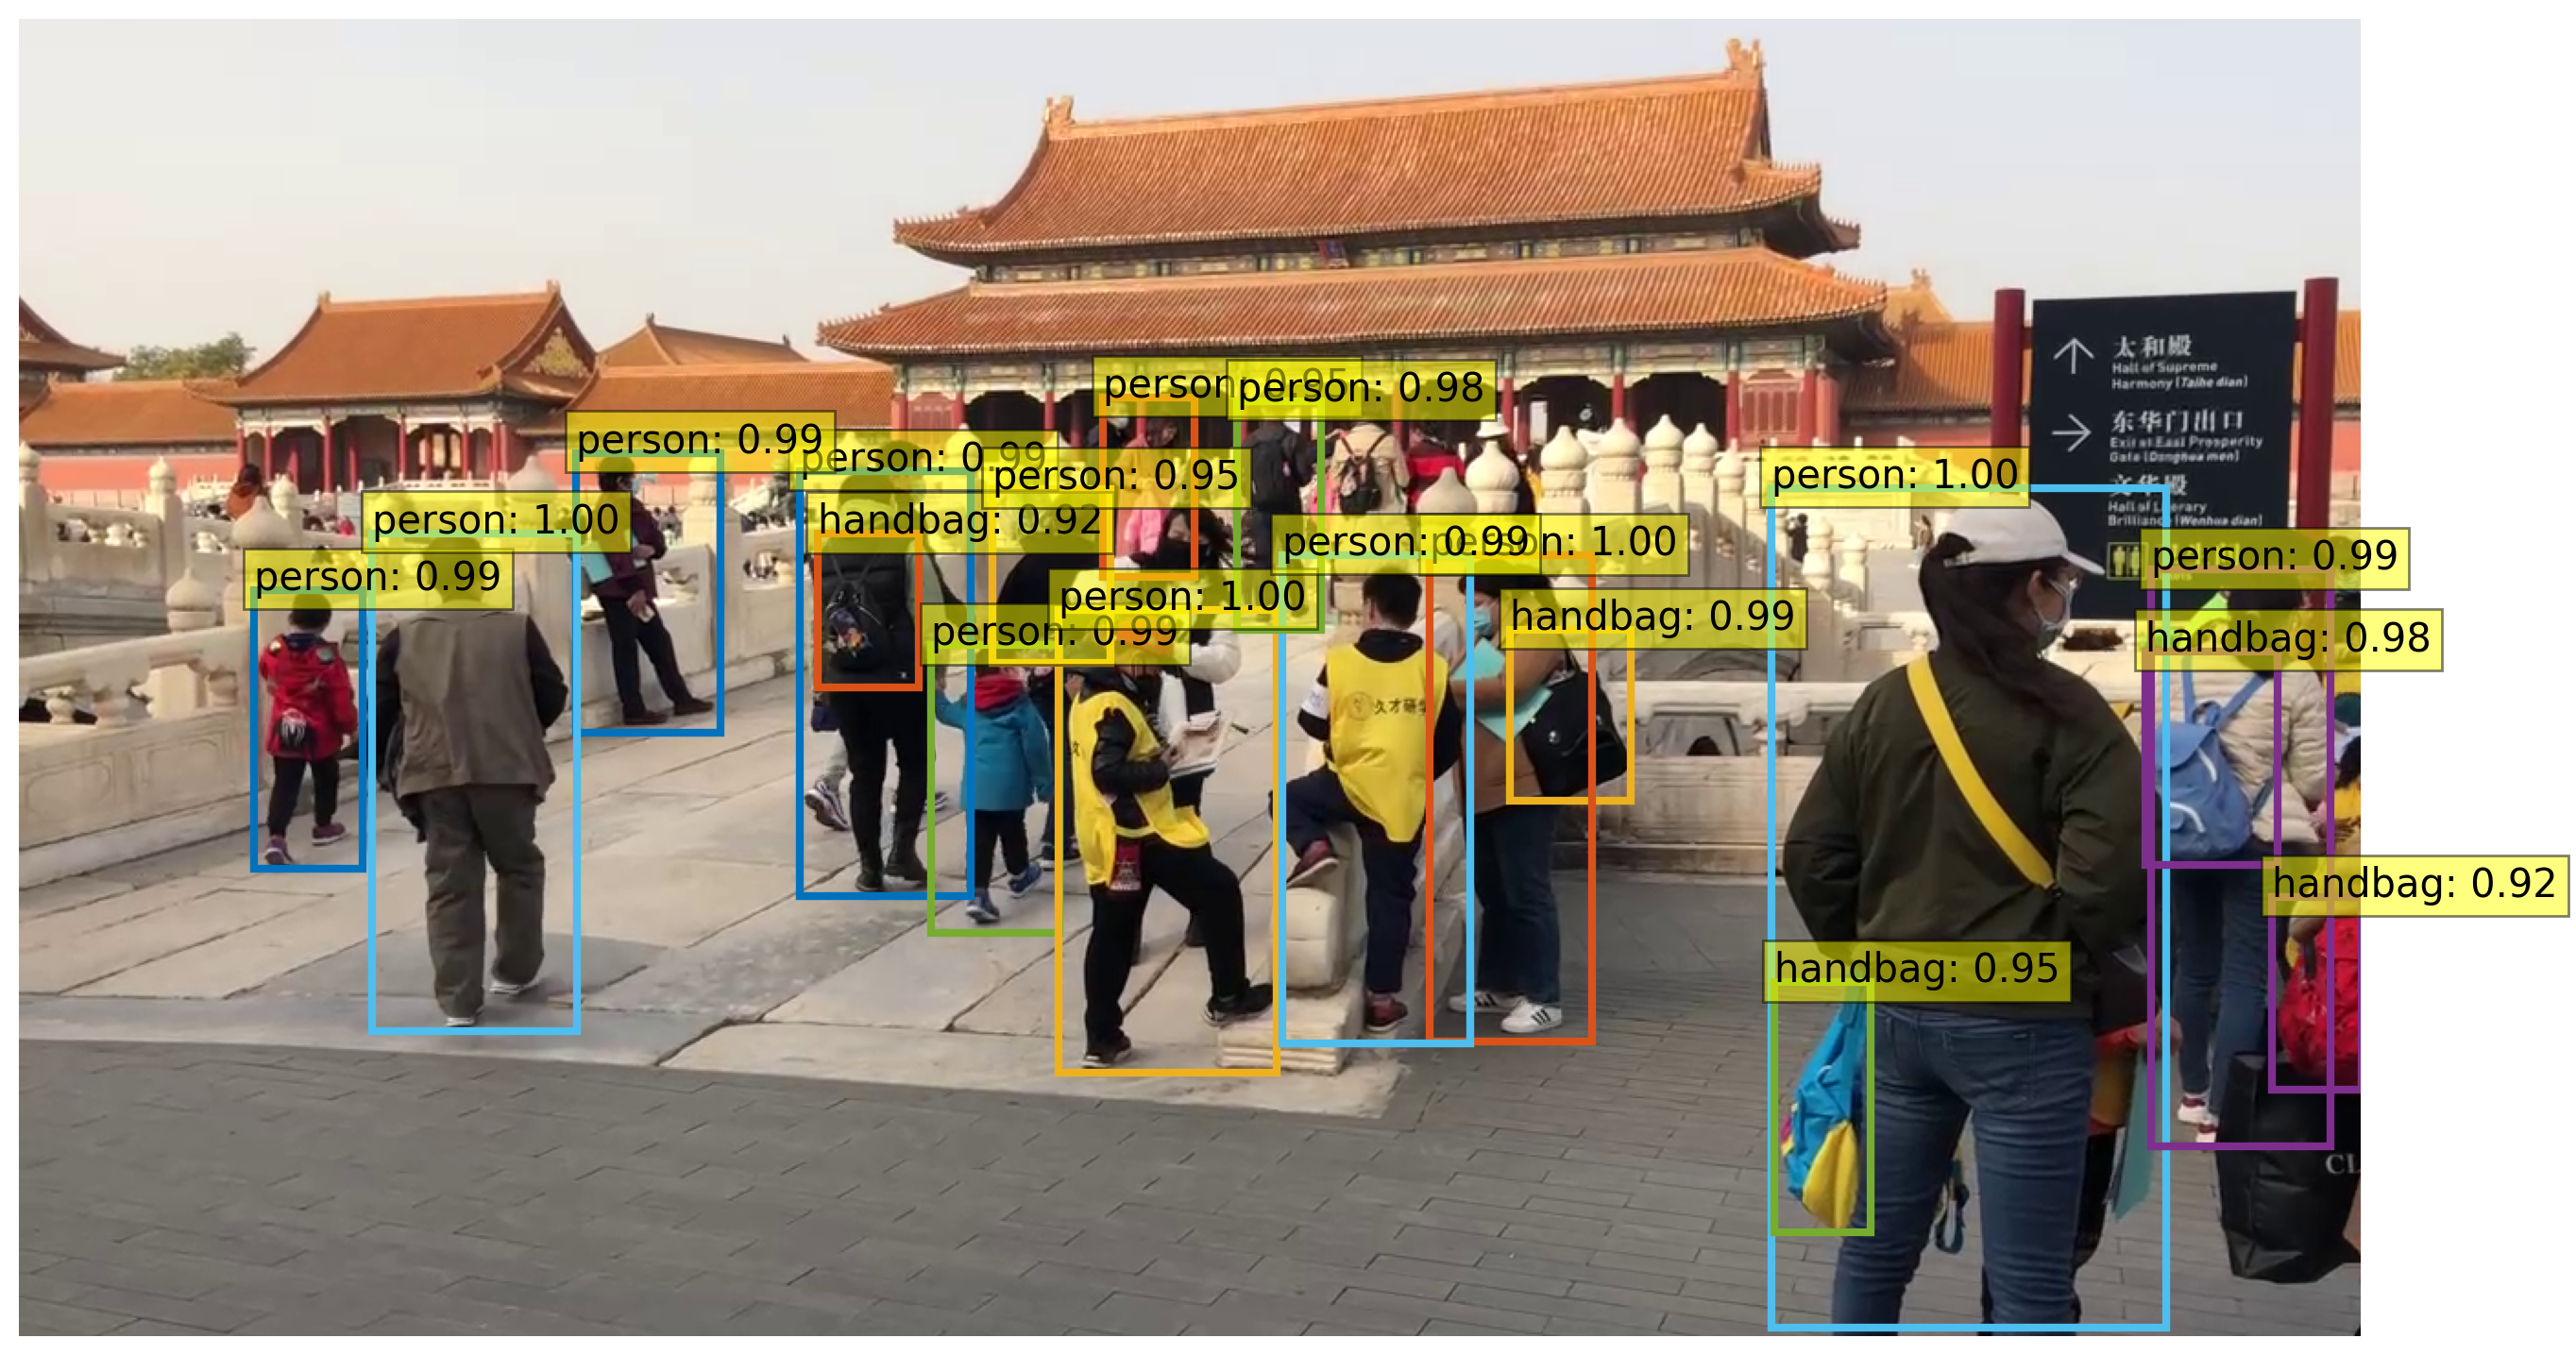

2025-06-28 09:26:40.257 | INFO     | __main__:imageflow_demo:121 - Processing frame 120 (10.94 fps)
2025-06-28 09:26:41.938 | INFO     | __main__:imageflow_demo:121 - Processing frame 140 (11.25 fps)
2025-06-28 09:26:43.616 | INFO     | __main__:imageflow_demo:121 - Processing frame 160 (11.50 fps)
2025-06-28 09:26:45.299 | INFO     | __main__:imageflow_demo:121 - Processing frame 180 (11.69 fps)
2025-06-28 09:26:46.971 | INFO     | __main__:imageflow_demo:121 - Processing frame 200 (11.86 fps)
2025-06-28 09:26:48.743 | INFO     | __main__:imageflow_demo:121 - Processing frame 220 (11.96 fps)
2025-06-28 09:26:50.634 | INFO     | __main__:imageflow_demo:121 - Processing frame 240 (12.00 fps)
2025-06-28 09:26:52.329 | INFO     | __main__:imageflow_demo:121 - Processing frame 260 (12.10 fps)
2025-06-28 09:26:54.013 | INFO     | __main__:imageflow_demo:121 - Processing frame 280 (12.20 fps)
2025-06-28 09:26:55.691 | INFO     | __main__:imageflow_demo:121 - Processing frame 300 (12.29 fps)


In [72]:
import os
import os.path as osp
import time
import cv2
import numpy as np

class A:
    track_thresh=0.5
    track_buffer=30
    match_thresh=0.8
    aspect_ratio_thresh=1.6
    min_box_area=10
    mot20=False
    conf=None
    nms=None
    tsize=None
    fps=30
    fp16=True
    fuse=True
    trt=False

ar = A()

%cd ByteTrack
!ls


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()





def get_image_list(path):
    image_names = []
    for maindir, subdir, file_name_list in os.walk(path):
        for filename in file_name_list:
            apath = osp.join(maindir, filename)
            ext = osp.splitext(apath)[1]
            if ext in IMAGE_EXT:
                image_names.append(apath)
    return image_names


def write_results(filename, results):
    save_format = '{frame},{id},{x1},{y1},{w},{h},{s},-1,-1,-1\n'
    with open(filename, 'w') as f:
        for frame_id, tlwhs, track_ids, scores in results:
            for tlwh, track_id, score in zip(tlwhs, track_ids, scores):
                if track_id < 0:
                    continue
                x1, y1, w, h = tlwh
                line = save_format.format(frame=frame_id, id=track_id, x1=round(x1, 1), y1=round(y1, 1), w=round(w, 1), h=round(h, 1), s=round(score, 2))
                f.write(line)
    logger.info('save results to {}'.format(filename))


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def imageflow_demo():
    vis_folder = '/YOLOX_outputs/yolox_x_mix_det/track_vis'
    current_time = time.localtime()
    cap = cv2.VideoCapture('videos/palace.mp4')
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
    fps = cap.get(cv2.CAP_PROP_FPS)
    timestamp = time.strftime("%Y_%m_%d_%H_%M_%S", current_time)
    save_folder = osp.join(vis_folder, timestamp)
    os.makedirs(save_folder, exist_ok=True)

    detr = DETRdemo(num_classes=91).cuda()
    state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth', map_location='cpu', check_hash=True)
    detr.load_state_dict(state_dict)
    detr.eval()

    save_path = osp.join(save_folder, ("/")[-1])

    vid_writer = cv2.VideoWriter('/YOLOX_outputs/yolox_x_mix_det/track_vis/DeTr_ByteTrack.mp4', cv2.VideoWriter_fourcc(*"mp4v"), fps, (int(width), int(height)))

    tracker = BYTETracker(ar, frame_rate=30)
    timer = Timer()
    frame_id = 0
    results = []
    transform = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    while True:
        timer.tic()
        if frame_id % 20 == 0:
            logger.info('Processing frame {} ({:.2f} fps)'.format(frame_id, 1. / max(1e-5, timer.average_time)))
        ret_val, frame = cap.read()
        if ret_val:
            #outputs, img_info = predictor.inference(frame, timer)

            img = transform(frame).unsqueeze(0).cuda()
            outputs = detr(img)

            # keep only predictions with 0.7+ confidence
            probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
            keep = probas.max(-1).values > 0.9
            # convert boxes from [0; 1] to image scales
            bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], (width, height))

            if frame_id == 100: plot_results(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), probas[keep], bboxes_scaled)

            lst = []
            for i, cls in enumerate(probas[keep]):
                cl = cls.argmax()
                if cl == 1:
                    lst.append([int(bboxes_scaled[i, 0]), int(bboxes_scaled[i, 1]), int(bboxes_scaled[i, 2]),
                                int(bboxes_scaled[i, 3]), cl, cls[cl], 0])

            outputs = [torch.from_numpy(np.array(lst))]


            height, width = frame.shape[:2]
            img_info = {"id": 0}
            img_info["height"] = height
            img_info["width"] = width
            img_info["raw_img"] = frame
            #img, ratio = preproc(frame, exp.test_size, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            #img_info["ratio"] = ratio

            h = 1440/frame.shape[1]
            v = 800/frame.shape[0]
            lst = []
            for i, cls in enumerate(probas[keep]):
                cl = cls.argmax()
                if cl == 1:
                    lst.append([int(bboxes_scaled[i, 0])*h, int(bboxes_scaled[i, 1])*v, int(bboxes_scaled[i, 2])*h,
                                int(bboxes_scaled[i, 3])*v, cl, cls[cl], 0])

            outputs = [torch.from_numpy(np.array(lst))]

            #print(frame.shape, img.shape)

            if outputs[0] is not None:
                online_targets = tracker.update(outputs[0], [img_info['height'], img_info['width']], (width, height))
                online_tlwhs = []
                online_ids = []
                online_scores = []
                for t in online_targets:
                    tlwh = t.tlwh
                    tid = t.track_id
                    vertical = tlwh[2] / tlwh[3] > ar.aspect_ratio_thresh
                    if tlwh[2] * tlwh[3] > ar.min_box_area and not vertical:
                        online_tlwhs.append(tlwh)
                        online_ids.append(tid)
                        online_scores.append(t.score)
                        results.append(
                            f"{frame_id},{tid},{tlwh[0]:.2f},{tlwh[1]:.2f},{tlwh[2]:.2f},{tlwh[3]:.2f},{t.score:.2f},-1,-1,-1\n"
                        )
                timer.toc()
                online_im = plot_tracking(
                    frame, online_tlwhs, online_ids, frame_id=frame_id + 1, fps=1. / timer.average_time
                )
            else:
                timer.toc()
                online_im = frame

            vid_writer.write(online_im)

        else:
            break
        frame_id += 1


    res_file = osp.join(vis_folder, f"{timestamp}.txt")
    with open(res_file, 'w') as f:
        f.writelines(results)
    logger.info(f"save results to {res_file}")

imageflow_demo()